In [1]:
import kmeans, library
from matplotlib import pyplot
import time
import numpy
import random
from sklearn.decomposition import PCA
import seaborn

In [18]:
def get_silhouette(cluster_results):
    # Using equations from
    # https://en.wikipedia.org/wiki/Silhouette_%28clustering%29
    cohesion = {}
    separation = {}
    # Calculate cohesions
    for cluster in cluster_results.clusters:
        cluster_size = len(cluster)
        cluster_cohesion = 0
        cluster_doc_names = []
        if cluster_size == 1:
            # If cluster only contains one document, want silhouette to be 0
            cohesion[cluster[0][0]] = 1
            separation[cluster[0][0]] = 1
        else:
            for i in range(len(cluster)):
                doc_i = cluster[i]
                cluster_doc_names.append(doc_i[0])
                # Calculate separation for doc_i
                dist_to_centroids = []
                for centroid in cluster_results.centroids:
                    dist_to_centroids.append(kmeans.item_distance_dot_product(doc_i, centroid))
                # min dist is assigned cluster's centroid, want 2nd min
                doc_2nd_min_dist = sorted(set(dist_to_centroids))[1]
                separation[doc_i[0]] = doc_2nd_min_dist / cluster_size
                # Continue to copute cohesion
                for j in range(i, len(cluster)):
                    doc_j = cluster[j]
                    cluster_cohesion += kmeans.item_distance_dot_product(doc_i, doc_j)
            for doc_name in cluster_doc_names:
                cohesion[doc_name] = cluster_cohesion / (cluster_size - 1)
    
    # Compute average of silhouettes
    silhouette = 0
    for doc_name in cohesion.keys():
        silhouette += (separation[doc_name] - cohesion[doc_name]) / max(separation[doc_name], cohesion[doc_name])
    return silhouette / len(cohesion)

In [2]:
def optimal_k_WCSS(K, WCSS,threshold):
    for i in range(1,len(WCSS)):
        if WCSS[i-1]-WCSS[i] < threshold:
            return K[i-1]
    return len(WCSS)

def optimal_k_silhouette(K,silhouettes):
    max_idx = 0
    for i in range(1,len(silhouettes)):
        if silhouettes[max_idx] < silhouettes[i]:
            max_idx = i
    return K[max_idx]

In [24]:
def reduce_to_2d(cluster_results, vocab, k):
    # Depricated
    # Use k random words to represent docs, then PCA
    random_words = set([])
    while len(random_words) < k:
        random_words.update([random.randint(0, len(vocab['words'])-1)])
    X = []
    labels = []
    for i in range(len(cluster_results.clusters)):
        cluster = cluster_results.clusters[i]
        for j in range(len(cluster)):
            doc = cluster[j]
            row = numpy.zeros(shape=k)
            for m in range(k):
                if m in doc[1].keys():
                    row[m] = doc[1][m]
                else:
                    row[m] = 0
            X.append(row)
            labels.append(i)
    pca = PCA(n_components=2)
    X = pca.fit_transform(X)
    print(f'dim {k} -> 2 info preserved: {sum(pca.explained_variance_ratio_)}')
    return numpy.transpose(X), labels

In [30]:
def reduce_to_2d(cluster_results, docs, vocab, k):
    # Use num_docs random words to represent docs, then PCA
    new_doc_length = min(len(docs), len(vocab['words']))
    random_words = set([])
    while len(random_words) < new_doc_length:
        random_words.update([random.randint(0, len(vocab['words'])-1)])
    X = []
    labels = []
    for i in range(len(cluster_results.clusters)):
        cluster = cluster_results.clusters[i]
        for j in range(len(cluster)):
            doc = cluster[j]
            row = numpy.zeros(shape=len(random_words))
            for m in range(len(random_words)):
                if m in doc[1].keys():
                    row[m] = doc[1][m]
                else:
                    row[m] = 0
            X.append(row)
            labels.append(i)
    pca = PCA(n_components=2)
    X = pca.fit_transform(X)
    print(f'dim {k} -> 2 info preserved: {sum(pca.explained_variance_ratio_)}')
    return numpy.transpose(X), labels

In [9]:
t0 = time.time()
pickle_dir = 'C:\\Users\\Colin\\Documents\\SCHOOL_STUFF\\EWU\\W21\\CSCD_530\\Project\\Code\\data_after_removing_words'

t = time.time()
num_docs = 200
vocab, docs = library.load_project(pickle_dir, num_docs, random_files=True)
print(f"loaded {num_docs:,} docs {time.time()-t:.2f}")

t = time.time()
sub_corpus_freqs = kmeans.sub_corpus_frequencies(docs)
print(f"recalc frequencies {time.time()-t:.2f}")  

loaded 200 docs 4.58
recalc frequencies 0.04


In [10]:
kmax = 10
K = []
WCSSE = []

for k in range(2,kmax):
    K.append(k)
    results = kmeans.find_clusters(docs, k)
    WCSSE.append(results.wcsse)
# Calculate optimal k
scaled_WCSSE = [x/WCSSE[0] for x in WCSSE]
optimal_k = kmeans.optimal_k_WCSSE(K, scaled_WCSSE, 0.025)
optimal_k_v2 = kmeans.optimal_k_WCSSEv2(K, WCSSE)

results = kmeans.find_clusters(docs, optimal_k_v2)

X, labels = library.reduce_to_2d(results, docs, vocab, optimal_k_v2)

k=2, iteration 1 (0.06s) [28, 172] skipped 0
centroid length: 337 (0.01s)
centroid length: 102 (0.05s)
k=2, iteration 2 (0.03s) [39, 161] skipped 0
centroid length: 315 (0.01s)
centroid length: 116 (0.04s)
k=2, iteration 3 (0.02s) [41, 159] skipped 0
centroid length: 314 (0.01s)
centroid length: 125 (0.04s)
k=2, iteration 4 (0.03s) [43, 157] skipped 0
centroid length: 303 (0.01s)
centroid length: 129 (0.04s)
k=2, iteration 5 (0.03s) [45, 155] skipped 0
centroid length: 294 (0.01s)
centroid length: 131 (0.04s)
k=2, iteration 6 (0.03s) [47, 153] skipped 0
centroid length: 291 (0.01s)
centroid length: 133 (0.04s)
k=2, iteration 7 (0.00s) [47, 153] skipped 172
wcsse (0.02s)
wcsse total: 157.79
k=3, iteration 1 (0.06s) [78, 15, 107] skipped 0
centroid length: 210 (0.02s)
centroid length: 681 (0.01s)
centroid length: 188 (0.03s)
k=3, iteration 2 (0.04s) [90, 17, 93] skipped 0
centroid length: 195 (0.02s)
centroid length: 617 (0.01s)
centroid length: 226 (0.03s)
k=3, iteration 3 (0.04s) [91, 

In [13]:
def plot_compare_k(K,WCSSE,optimal_k,optimal_k_v2):

    pyplot.rcParams["figure.figsize"] = (20,7)

    figure, axis = pyplot.subplots(1,2)
    figure.suptitle(f'Using {num_docs} Documents')

    axis[0].plot(K, WCSSE, color='b');
    axis[0].axvline(x=optimal_k_v2, color='r');
    axis[0].plot([K[0],K[-1]], [WCSSE[0],WCSSE[-1]], '--g');
    axis[0].set_title('Chosen Furthest Point From Line');
    axis[0].set_xlabel('k');
    axis[0].set_ylabel('WCSSE');

    axis[1].plot(K, scaled_WCSSE);
    axis[1].axvline(x=optimal_k, color='r');
    axis[1].set_title('Chosen by Change Threshold');
    axis[1].set_xlabel('k');
    axis[1].set_ylabel('Scaled WCSSE');

    pyplot.show()
    return

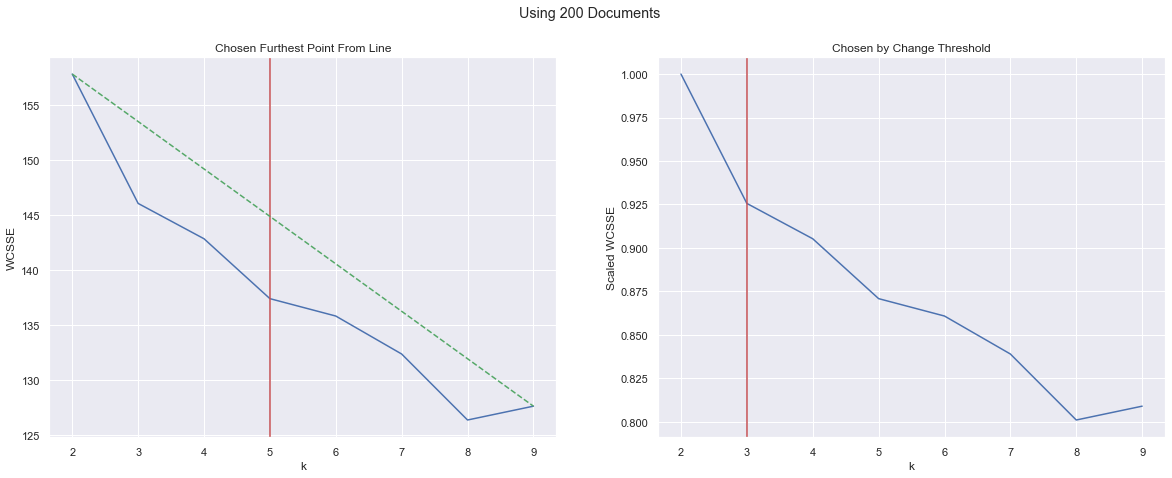

In [14]:
plot_compare_k(K,WCSSE,optimal_k,optimal_k_v2)

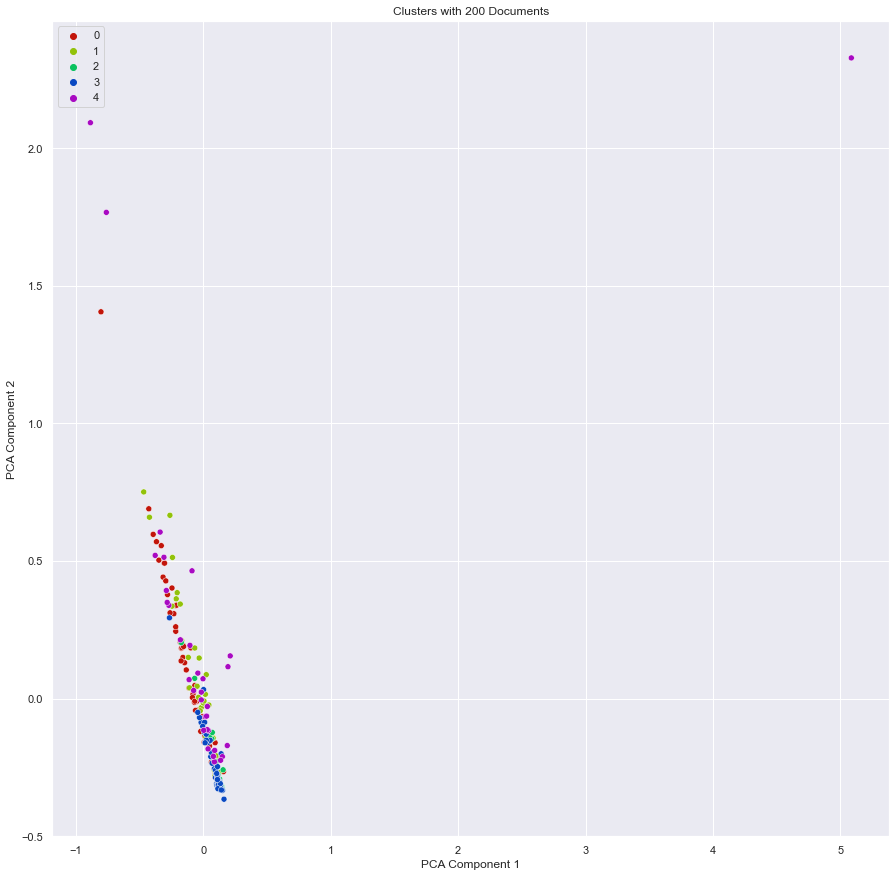

In [12]:
library.plot_clusters(X,labels,num_docs)